# 1. Setup and imports

In [2]:
import os
import json
import base64
from pathlib import Path
from io import BytesIO
from typing import List, Dict, Any, Optional

from pydantic import BaseModel, Field
from PIL import Image
from IPython.display import display

Loaded 3 card(s)


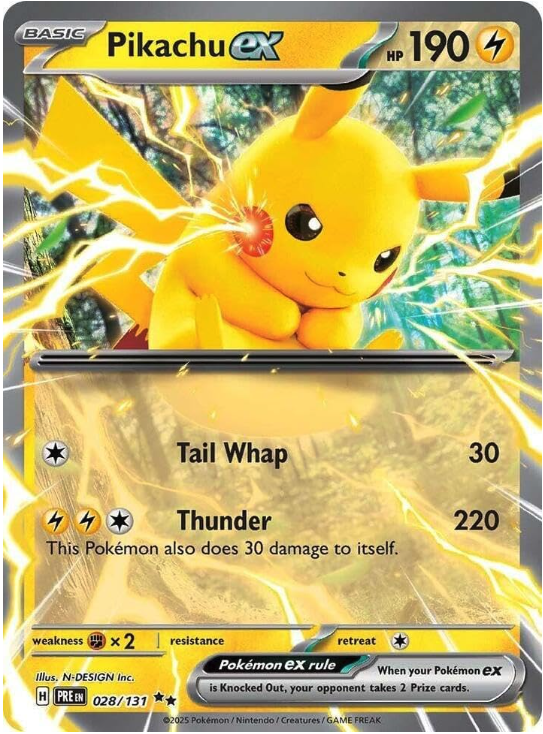

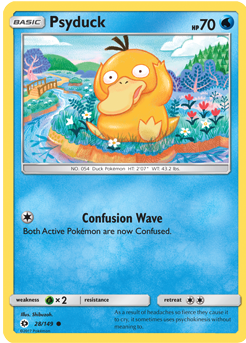

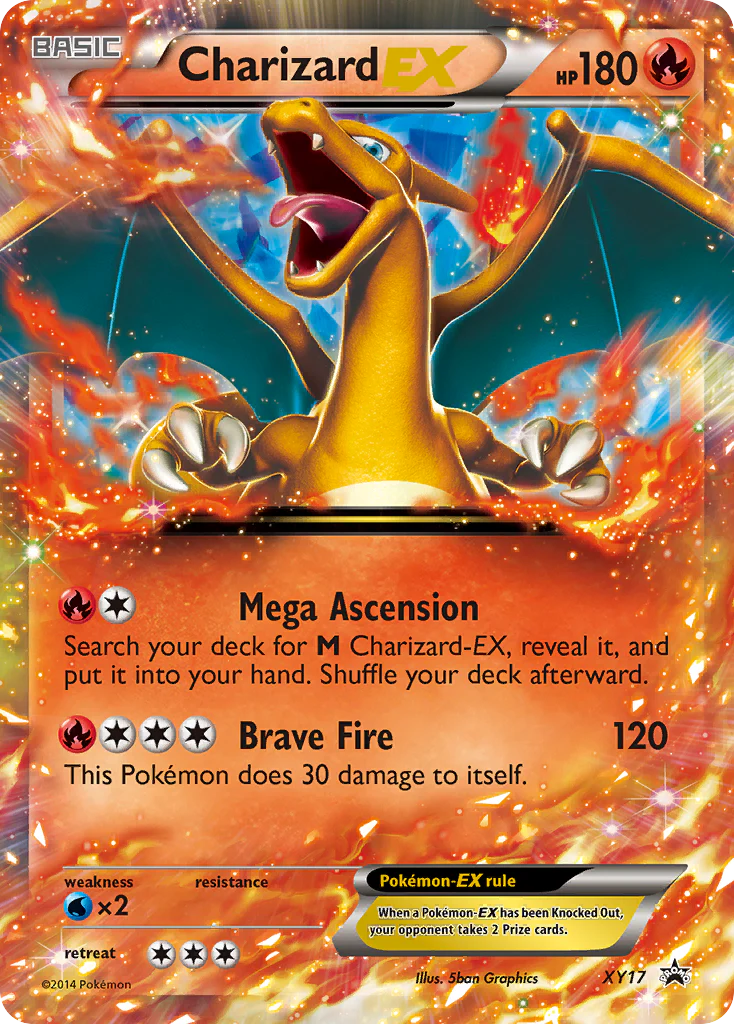

In [3]:
# One or more card images (paths or folder glob)
CARD_IMAGE_PATHS = [
    Path("pikachu_card.png"),
    Path("psyduck_card.png"),
    Path("charizard_card.png")
]
# Or load all PNGs from a folder: list(Path("cards").glob("*.png"))

def image_to_base64(img: Image.Image) -> str:
    buf = BytesIO()
    img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

# Load each card image and encode to base64 for the VLM
loaded_cards: List[tuple] = []  # (path, pil_image, base64)
for path in CARD_IMAGE_PATHS:
    if not path.exists():
        print(f"Skipping (not found): {path}")
        continue
    pil_image = Image.open(path).convert("RGB")
    b64 = image_to_base64(pil_image)
    loaded_cards.append((path, pil_image, b64))

print(f"Loaded {len(loaded_cards)} card(s)")
for path, img, _ in loaded_cards:
    display(Image.open(path))

# 2. VLM: extract all card info to JSON

In [4]:
from google import genai
from google.genai import types
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

client = genai.Client()


# Pydantic schema for structured output (see https://ai.google.dev/gemini-api/docs/structured-output)
class Attack(BaseModel):
    """A single attack on the card."""
    name: str = Field(description="Name of the attack.")
    cost: Optional[List[str]] = Field(default=None, description="Energy cost as list of symbols, e.g. ['Lightning', 'Colorless'].")
    damage: Optional[str] = Field(default=None, description="Damage dealt, e.g. '30' or '20+'.")
    effect: Optional[str] = Field(default=None, description="Effect text of the attack, if any.")


class PokemonCard(BaseModel):
    """Extracted Pokemon TCG card data from a card image."""
    name: str = Field(
        description="The Pokemon's species name only (e.g. 'Pikachu'). Do NOT include card variant suffixes like 'ex', 'GX', 'V', 'VMAX' that may appear next to the name on the card—those indicate card type, not the creature's name."
    )
    type: Optional[str] = Field(default=None, description="Element type, e.g. Lightning, Water, Fire.")
    hp: Optional[int] = Field(default=None, description="HP value.")
    stage: Optional[str] = Field(default=None, description="Stage, e.g. Basic, Stage 1.")
    description: Optional[str] = Field(default=None, description="Flavor text or ability description.")
    attacks: List[Attack] = Field(default_factory=list, description="List of attacks on the card.")
    weakness: Optional[str] = Field(default=None, description="Weakness, e.g. 'Fighting x2'.")
    resistance: Optional[str] = Field(default=None, description="Resistance, if any.")
    retreat_cost: Optional[int] = Field(default=None, description="Retreat cost (number).")
    illustrator: Optional[str] = Field(default=None, description="Illustrator name if visible.")
    set_info: Optional[str] = Field(default=None, description="Set name or number if visible.")


POKEMON_CARD_EXTRACT_PROMPT = """Analyze this Pokemon TCG card image and extract all visible information.
Fill in every field you can read; use null for anything not present on the card."""

In [5]:
def extract_card_with_schema(image_base64: str, prompt: str) -> PokemonCard:
    """Call Gemini with structured output so the response conforms to PokemonCard schema."""
    image_bytes = base64.b64decode(image_base64)
    image_part = types.Part.from_bytes(data=image_bytes, mime_type="image/png")
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=[prompt, image_part],
        config={
            "response_mime_type": "application/json",
            "response_json_schema": PokemonCard.model_json_schema(),
        },
    )
    return PokemonCard.model_validate_json(response.text)

# Process each card: extract structured data (path, model) for later chunking
all_cards_data: List[tuple] = []  # (path, PokemonCard model)
for path, _pil, b64 in loaded_cards:
    card_model = extract_card_with_schema(b64, POKEMON_CARD_EXTRACT_PROMPT)
    all_cards_data.append((path, card_model))
    print(f"[{path.name}] {card_model.name} | HP {card_model.hp} | {len(card_model.attacks)} attack(s)")

[pikachu_card.png] Pikachu | HP 190 | 2 attack(s)
[psyduck_card.png] Psyduck | HP 70 | 1 attack(s)
[charizard_card.png] Charizard | HP 180 | 2 attack(s)


In [19]:
# Print one card output as example
print(all_cards_data[0][1].model_dump_json(indent=2))

{
  "name": "Pikachu",
  "type": "Lightning",
  "hp": 190,
  "stage": "Basic",
  "description": "Pokémon ex rule: When your Pokémon ex is Knocked Out, your opponent takes 2 Prize cards.",
  "attacks": [
    {
      "name": "Tail Whap",
      "cost": [
        "Colorless"
      ],
      "damage": "30",
      "effect": null
    },
    {
      "name": "Thunder",
      "cost": [
        "Lightning",
        "Lightning",
        "Colorless"
      ],
      "damage": "220",
      "effect": "This Pokémon also does 30 damage to itself."
    }
  ],
  "weakness": "Fighting x2",
  "resistance": null,
  "retreat_cost": 1,
  "illustrator": "N-DESIGN Inc.",
  "set_info": "028/131"
}


In [20]:
# Build (source_id, card_json) for each card so chunk IDs are unique across cards
# source_id = pokemon_name + path stem (e.g. pikachu_pikachu_card) to support duplicate names
def card_source_id(name: str, path: Path) -> str:
    safe_name = (name or "card").lower().replace(" ", "_")
    return f"{safe_name}_{path.stem}"

all_cards_for_chunking: List[tuple] = [
    (card_source_id(model.name, path), model.model_dump(mode="json"))
    for path, model in all_cards_data
]
for source_id, card_json in all_cards_for_chunking:
    print(f"  {source_id}: {card_json.get('name')} (HP {card_json.get('hp')})")

  pikachu_pikachu_card: Pikachu (HP 190)
  psyduck_psyduck_card: Psyduck (HP 70)
  charizard_charizard_card: Charizard (HP 180)


# 3. Chunking structured JSON for embedding

Split the card JSON into semantic chunks (one per top-level key or logical group) for embedding.

In [21]:
def chunk_card_json(data: Dict[str, Any], source: str = "card") -> List[Dict[str, Any]]:
    """Split card JSON into semantic chunks (one per top-level key or logical group)."""
    chunks = []
    base = {"source": source}

    # Basic info chunk
    basic = {k: data[k] for k in ("name", "type", "hp", "stage") if k in data and data[k] is not None}
    if basic:
        chunks.append({
            "chunk_id": f"{source}_basic",
            "chunk_type": "text",
            "text": " | ".join(f"{k}: {v}" for k, v in basic.items()),
            "metadata": {**base, "section": "basic"},
        })

    # Description
    if data.get("description"):
        chunks.append({
            "chunk_id": f"{source}_description",
            "chunk_type": "text",
            "text": str(data["description"]),
            "metadata": {**base, "section": "description"},
        })

    # Attacks
    attacks = data.get("attacks") or []
    for i, a in enumerate(attacks):
        parts = [f"Attack: {a.get('name', '')}"]
        if a.get("cost"):
            parts.append(f"Cost: {a['cost']}")
        if a.get("damage"):
            parts.append(f"Damage: {a['damage']}")
        if a.get("effect"):
            parts.append(f"Effect: {a['effect']}")
        chunks.append({
            "chunk_id": f"{source}_attack_{i}",
            "chunk_type": "text",
            "text": " | ".join(parts),
            "metadata": {**base, "section": "attack", "index": i},
        })

    # Weakness, resistance, retreat
    extra = {k: data[k] for k in ("weakness", "resistance", "retreat_cost") if k in data and data[k] is not None}
    if extra:
        chunks.append({
            "chunk_id": f"{source}_stats",
            "chunk_type": "text",
            "text": " | ".join(f"{k}: {v}" for k, v in extra.items()),
            "metadata": {**base, "section": "stats"},
        })

    # Set / illustrator
    misc = {k: data[k] for k in ("illustrator", "set_info") if k in data and data[k] is not None}
    if misc:
        chunks.append({
            "chunk_id": f"{source}_misc",
            "chunk_type": "text",
            "text": " | ".join(f"{k}: {v}" for k, v in misc.items()),
            "metadata": {**base, "section": "misc"},
        })

    return chunks

# Chunk every card and combine; each chunk has unique chunk_id (source_basic, source_attack_0, ...)
card_chunks: List[Dict[str, Any]] = []
for source_id, card_json in all_cards_for_chunking:
    card_chunks.extend(chunk_card_json(card_json, source=source_id))

print(f"Created {len(card_chunks)} chunks from {len(all_cards_for_chunking)} card(s):")
for c in card_chunks:
    t = (c["text"] or "")[:60]
    if len(c.get("text") or "") > 60:
        t += "..."
    print(f"  {c['chunk_id']}: {t}")

Created 16 chunks from 3 card(s):
  pikachu_pikachu_card_basic: name: Pikachu | type: Lightning | hp: 190 | stage: Basic
  pikachu_pikachu_card_description: Pokémon ex rule: When your Pokémon ex is Knocked Out, your o...
  pikachu_pikachu_card_attack_0: Attack: Tail Whap | Cost: ['Colorless'] | Damage: 30
  pikachu_pikachu_card_attack_1: Attack: Thunder | Cost: ['Lightning', 'Lightning', 'Colorles...
  pikachu_pikachu_card_stats: weakness: Fighting x2 | retreat_cost: 1
  pikachu_pikachu_card_misc: illustrator: N-DESIGN Inc. | set_info: 028/131
  psyduck_psyduck_card_basic: name: Psyduck | type: Water | hp: 70 | stage: Basic
  psyduck_psyduck_card_description: As a result of headaches so fierce they cause it to cry, it ...
  psyduck_psyduck_card_attack_0: Attack: Confusion Wave | Cost: ['Colorless'] | Effect: Both ...
  psyduck_psyduck_card_stats: weakness: Grass x2 | retreat_cost: 3
  psyduck_psyduck_card_misc: illustrator: Shibuzoh. | set_info: 28/149
  charizard_charizard_card_basic:

# 4. ChromaDB: embedding and storage

Embed each chunk with Google Genai (`gemini-embedding-001`) and store in a persistent ChromaDB collection.

In [22]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/

In [23]:
import chromadb
from google.genai import types

COLLECTION_NAME = "pokemon_cards"
EMBEDDING_MODEL = "gemini-embedding-001"

chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name=COLLECTION_NAME)

In [24]:
def embed_texts(texts: List[str], task_type: str = "RETRIEVAL_DOCUMENT") -> List[List[float]]:
    """Embed texts with Genai. Use RETRIEVAL_DOCUMENT for index, RETRIEVAL_QUERY for queries."""
    config = types.EmbedContentConfig(task_type=task_type)
    result = client.models.embed_content(
        model=EMBEDDING_MODEL,
        contents=texts,
        config=config,
    )
    return [e.values for e in result.embeddings]

existing = collection.get(ids=[c["chunk_id"] for c in card_chunks])
existing_ids = set[Any](existing.get("ids", []))

to_add = [c for c in card_chunks if c["chunk_id"] not in existing_ids and c.get("text", "").strip()]
if to_add:
    texts_to_embed = [c["text"].strip() for c in to_add]
    embeddings = embed_texts(texts_to_embed, task_type="RETRIEVAL_DOCUMENT")
    for chunk, emb in zip(to_add, embeddings):
        cid = chunk["chunk_id"]
        text = chunk["text"].strip()
        meta = {"chunk_type": chunk.get("chunk_type", "text"), **chunk.get("metadata", {})}
        for k, v in list(meta.items()):
            if v is None or (isinstance(v, (list, dict)) and not v):
                meta.pop(k, None)
            elif not isinstance(v, (str, int, float, bool)):
                meta[k] = str(v)
        collection.add(documents=[text], ids=[cid], metadatas=[meta], embeddings=[emb])

print(f"Added {len(to_add)} new chunks to ChromaDB.")

Added 16 new chunks to ChromaDB.


# 5. Retrieval

Query the vector store by embedding the question and retrieving the most similar chunks.

In [25]:
def query_card_db(question: str, top_k: int = 3, threshold: float = 0.2):
    [q_emb] = embed_texts([question], task_type="RETRIEVAL_QUERY")
    results = collection.query(
        query_embeddings=[q_emb],
        n_results=top_k,
        include=["documents", "metadatas", "distances"],
    )
    docs = results["documents"][0]
    metas = results["metadatas"][0]
    dists = results["distances"][0]
    ids_list = results.get("ids")
    ids = ids_list[0] if ids_list else [None] * len(docs)

    print(f"Query: {question}\n" + "=" * 60)
    found_any = False
    for i, (text, meta, dist, cid) in enumerate(zip(docs, metas, dists, ids)):
        sim = 1 - dist
        if sim < threshold:
            continue
        found_any = True
        print(f"  [{i+1}] similarity={sim:.3f} | {cid}")
        preview = (text or "")[:120]
        if len(text or "") > 120:
            preview += "..."
        print(f"      {preview}")
        print()
    if not found_any:
        print("No results above similarity threshold.")
    return results

query_card_db("What is the Pikachu's HP and type?")

Query: What is the Pikachu's HP and type?
  [1] similarity=0.549 | pikachu_pikachu_card_basic
      name: Pikachu | type: Lightning | hp: 190 | stage: Basic

  [2] similarity=0.372 | pikachu_pikachu_card_stats
      weakness: Fighting x2 | retreat_cost: 1

  [3] similarity=0.353 | charizard_charizard_card_stats
      weakness: Water x2 | retreat_cost: 3



{'ids': [['pikachu_pikachu_card_basic',
   'pikachu_pikachu_card_stats',
   'charizard_charizard_card_stats']],
 'embeddings': None,
 'documents': [['name: Pikachu | type: Lightning | hp: 190 | stage: Basic',
   'weakness: Fighting x2 | retreat_cost: 1',
   'weakness: Water x2 | retreat_cost: 3']],
 'uris': None,
 'included': ['documents', 'metadatas', 'distances'],
 'data': None,
 'metadatas': [[{'section': 'basic',
    'chunk_type': 'text',
    'source': 'pikachu_pikachu_card'},
   {'source': 'pikachu_pikachu_card',
    'section': 'stats',
    'chunk_type': 'text'},
   {'source': 'charizard_charizard_card',
    'chunk_type': 'text',
    'section': 'stats'}]],
 'distances': [[0.45058193802833557, 0.6280868053436279, 0.6465027928352356]]}

In [41]:
query_card_db("What attacks does Psyduck card have and how much damage?", top_k=5)

Query: What attacks does Psyduck card have and how much damage?
  [1] similarity=0.496 | psyduck_psyduck_card_basic
      name: Psyduck | type: Water | hp: 70 | stage: Basic

  [2] similarity=0.418 | pikachu_pikachu_card_attack_0
      Attack: Tail Whap | Cost: ['Colorless'] | Damage: 30

  [3] similarity=0.401 | pikachu_pikachu_card_attack_1
      Attack: Thunder | Cost: ['Lightning', 'Lightning', 'Colorless'] | Damage: 220 | Effect: This Pokémon also does 30 damage...

  [4] similarity=0.382 | pikachu_pikachu_card_stats
      weakness: Fighting x2 | retreat_cost: 1

  [5] similarity=0.378 | psyduck_psyduck_card_attack_0
      Attack: Confusion Wave | Cost: ['Colorless'] | Effect: Both Active Pokémon are now Confused.



{'ids': [['psyduck_psyduck_card_basic',
   'pikachu_pikachu_card_attack_0',
   'pikachu_pikachu_card_attack_1',
   'pikachu_pikachu_card_stats',
   'psyduck_psyduck_card_attack_0']],
 'embeddings': None,
 'documents': [['name: Psyduck | type: Water | hp: 70 | stage: Basic',
   "Attack: Tail Whap | Cost: ['Colorless'] | Damage: 30",
   "Attack: Thunder | Cost: ['Lightning', 'Lightning', 'Colorless'] | Damage: 220 | Effect: This Pokémon also does 30 damage to itself.",
   'weakness: Fighting x2 | retreat_cost: 1',
   "Attack: Confusion Wave | Cost: ['Colorless'] | Effect: Both Active Pokémon are now Confused."]],
 'uris': None,
 'included': ['documents', 'metadatas', 'distances'],
 'data': None,
 'metadatas': [[{'source': 'psyduck_psyduck_card',
    'chunk_type': 'text',
    'section': 'basic'},
   {'chunk_type': 'text',
    'section': 'attack',
    'source': 'pikachu_pikachu_card',
    'index': 0},
   {'section': 'attack',
    'index': 1,
    'chunk_type': 'text',
    'source': 'pikachu

# 6. RAG with Google ADK + Genai

Use an ADK agent with a custom retrieval tool (ChromaDB + Genai embeddings) and Gemini to answer questions from the card context.

In [27]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types
import asyncio

def retrieve_card_context(question: str, top_k: int = 10) -> dict:
    """
    Searches the Chroma collection of stored Pokemon cards and returns relevant chunks for the question.
    Use this to answer questions about which cards are in the collection, e.g. attacks, types, names.
    Args:
        question (str): The user's question about the stored cards (e.g. 'Do I have any pokemon that knows Thunder attack?').
        top_k (int, optional): Number of chunks to retrieve. Defaults to 10. Use more for broad questions.
    Returns:
        dict: Contains 'context' (retrieved text from one or more cards) and 'status'.
    """
    [q_emb] = embed_texts([question], task_type="RETRIEVAL_QUERY")
    results = collection.query(
        query_embeddings=[q_emb],
        n_results=top_k,
        include=["documents", "metadatas"],
    )
    docs = results["documents"][0]
    metas = results.get("metadatas", [[]])[0] if results.get("metadatas") else []
    parts = []
    for i, (text, meta) in enumerate(zip(docs or [], metas or [])):
        source = (meta or {}).get("source", "card")
        parts.append(f"[{source}]\n{text}")
    context = "\n\n".join(parts) if parts else "No relevant context found."
    return {"context": context, "status": "success"}

rag_agent = Agent(
    model="gemini-2.5-flash",
    name="pokemon_card_rag",
    instruction=(
        "You answer questions about the Pokemon TCG cards stored in the Chroma collection. "
        "Always use the retrieve_card_context tool with the user's question to search the collection. "
        "Answer based only on the retrieved context: name specific cards, attacks, types, etc. "
        "Examples: 'Do I have any pokemon that knows Thunder attack?', 'Which cards are Lightning type?', 'What is the HP of my Pikachu?'. "
        "If the context does not contain the answer, say so clearly (e.g. 'None of the stored cards match that.')."
    ),
    tools=[retrieve_card_context],
)

APP_NAME = "pokemon_rag"
USER_ID = "user1"
SESSION_ID = "session1"

# Session and Runner
session_service = InMemorySessionService()
await session_service.create_session(app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID)
runner = Runner(agent=rag_agent, app_name=APP_NAME, session_service=session_service)

# Agent Interaction
def call_agent(query):
    content = types.Content(role='user', parts=[types.Part(text=query)])
    events = runner.run(user_id=USER_ID, session_id=SESSION_ID, new_message=content)

    for event in events:
        # print(f"\nDEBUG EVENT: {event}\n")
        if event.is_final_response() and event.content:
            final_answer = event.content.parts[0].text.strip()
            print("\n🟢 FINAL ANSWER\n", final_answer, "\n")

In [30]:
call_agent("Do I have any pokemon that knows Thunder attack?")


🟢 FINAL ANSWER
 Yes, you have a Pikachu card that knows the Thunder attack. It has a cost of [Lightning, Lightning, Colorless], deals 220 damage, and causes 30 damage to itself. 



In [42]:
call_agent("What attacks does Charizard card have and how much damage?")


🟢 FINAL ANSWER
 Charizard has two attacks:

1.  **Brave Fire**: It costs [Fire, Colorless, Colorless, Colorless] and deals 120 damage. This Pokémon also does 30 damage to itself.
2.  **Mega Ascension**: It costs [Fire, Colorless]. Its effect is to search your deck for M Charizard-EX, reveal it, and put it into your hand. You then shuffle your deck afterward. 



In [43]:
call_agent("What pokemon card has more HP?")


🟢 FINAL ANSWER
 Pikachu has 190 HP, Charizard has 180 HP, and Psyduck has 70 HP. Therefore, Pikachu has more HP than the other cards. 

